# Capstone Project: US Arrests

In [105]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["OMP_NUM_THREADS"] = '1' # To avoid KMeans memory leak on Windows with MKL userwarning

import seaborn as sns

### Exploring the data

In [107]:
#Import the data
df = pd.read_csv('UsArrests.csv', index_col='City')
df.index.names = ['State']
df.head()

,Murder,Assault,UrbanPop,Rape
State,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


The dataset imported contains crime statistics across each of the 50 states in the United States. The statistics are related to arrests per 100,000 residents for the following:
* Murder
* Assault
* Rape

The data also provides the percentage of the population in each state that lives in an urban population. Dubbed:
* UrbanPop

In [95]:
#Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


From the information displayed above on the dataframe we see that there are no null values in the dataset that need to be handled.

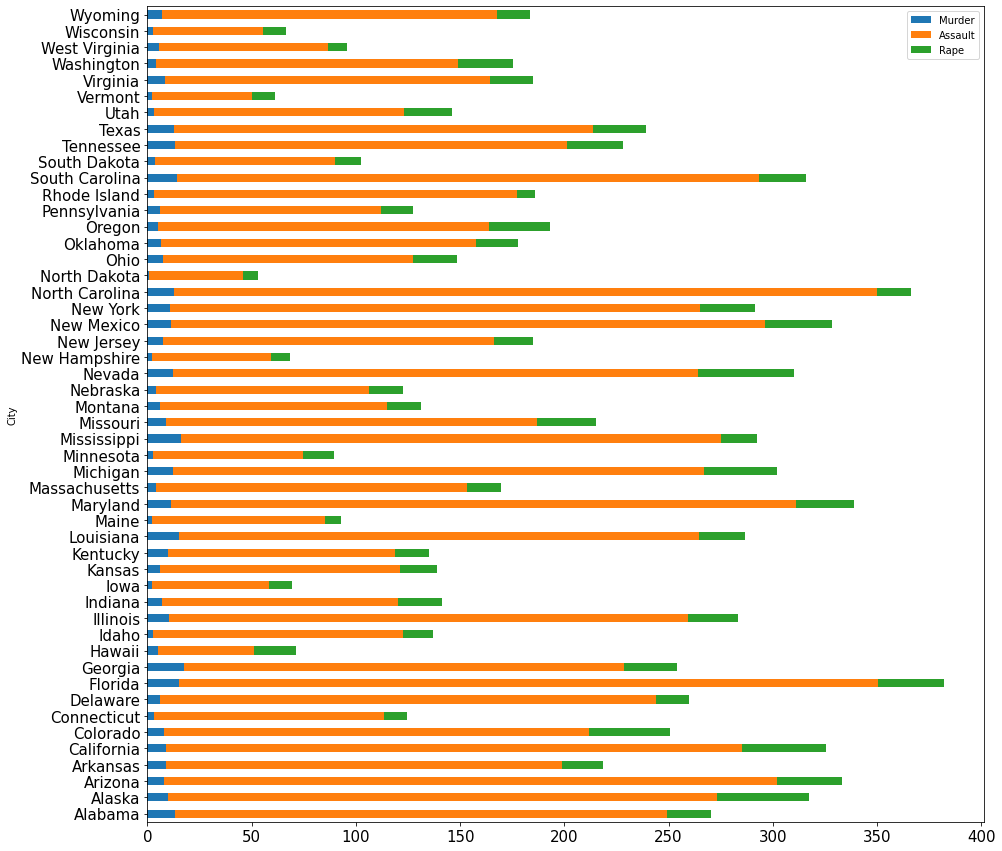

In [92]:
#Stacked barplot; murder, assault, rape - by state
plt.rcParams['figure.figsize'] = [15, 15]
ax =df.drop(columns = ['UrbanPop']).plot(kind='barh', stacked=True, fontsize = 15)

From the bar chart above, which shows visually the number of crimes in each state we can make several observations:
* Assault cases make up the overwhelming amount of criminal arrests
* Florida & North Caroline have the highest amount of assault cases
* Hawaii, Vermont, Wisconsin, and North Dakota have the lowest assault cases
* Georgia and Mississippi have high murder cases
* Idaho, Maine, and Iowa all have low murder cases
* Alaska and Nevada have relatively highr rape arrests
* Maine, Vermont, and New Hampshire have especially low rape arrests

### Distribution and Correlation Analysis

The pairplot below shows us the distribution of each variable via the histograms along the diagonal as well as scatterplots of each of the variables with one another. Adding the linear regression line of best fit allows us to better understand how the variables are related. Some observations include:
* Assault, murder, and rape display a high positive correlation amongst themselves
* UrbanPop has slightly positive but not necessarily statistically significant relationship with the other variables

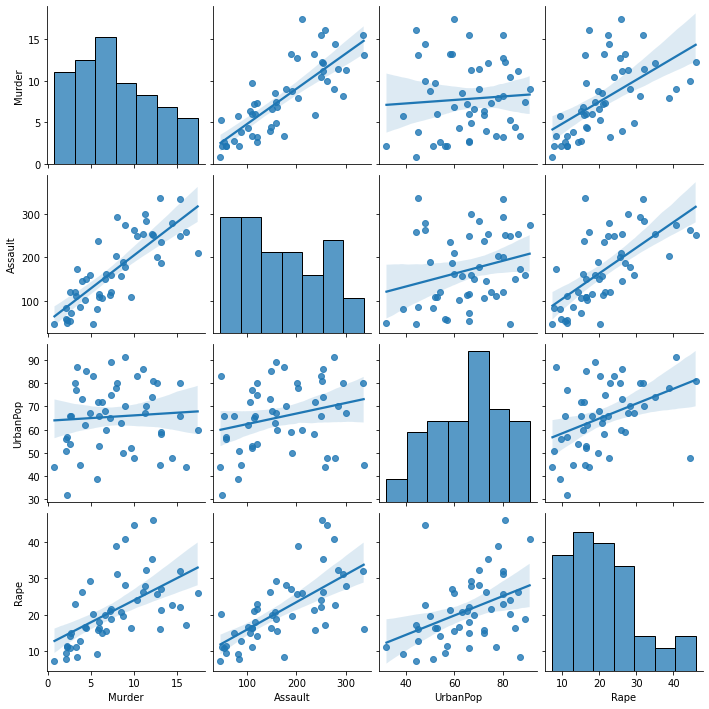

In [97]:
#pairplot of variables
sns.pairplot(df, palette = 'bright', kind='reg')

The heatmap below shows us the correlation between the variables:
* Murder has high positive correlation with Assault
* Assault and rape have high positive correlation
* rape and murder have high positive correlation
* Urban population and rape have moderate positive correlation
* Urban population has relatively low positive correlation with murder and assault

<AxesSubplot:>

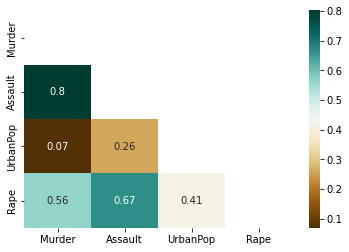

In [114]:
#Heatmap of variables

# to mask mirrored side of heatmap
dropSelf = np.zeros_like(df.corr())
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.heatmap(df.corr(), annot = True, cmap='BrBG', mask = dropSelf)

Since we see high positive correlation between variables, this dataset could be well suited to benefit from principal component analysis (PCA).

## Principal Component Analysis

In [120]:
#Preparing for PCA
from sklearn.decomposition import PCA
np.set_printoptions(precision=2)

X = df.values.squeeze() #Creates list of lists (each row)

std_pca = PCA()

In [123]:
#Standardize the data and run PCA
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)

In [136]:
#From the example ipynb
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots(figsize=(15, 15))    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = df.index[i] #had to edit this to the index of my df
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

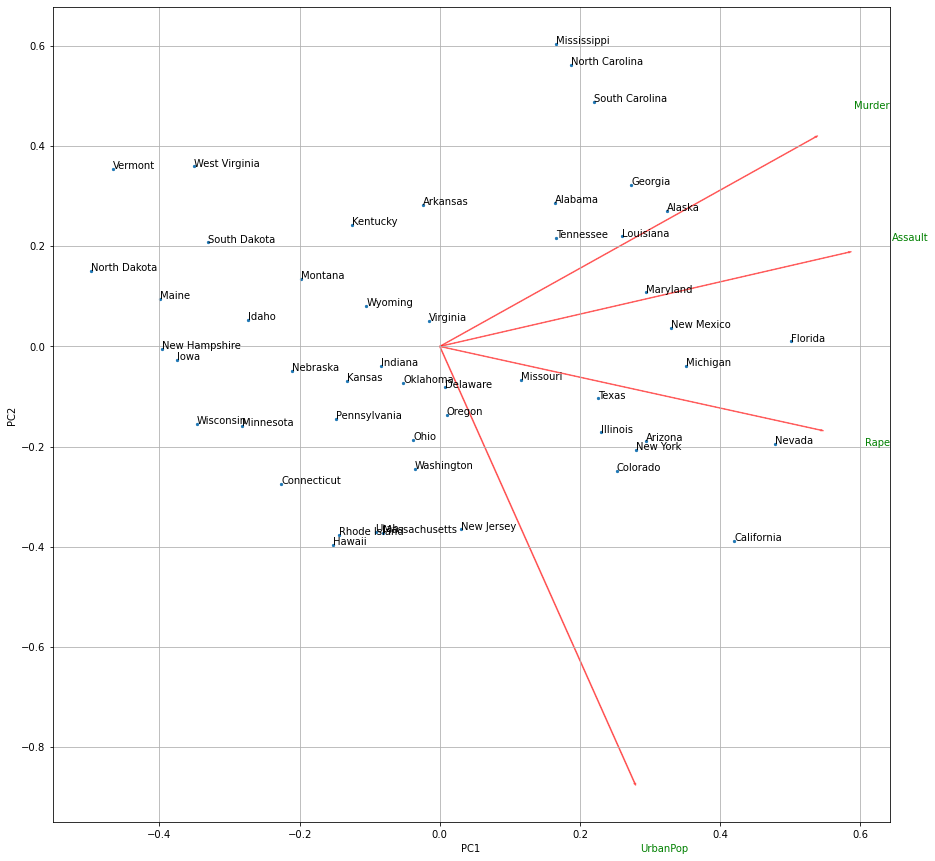

In [137]:
#Biplot
corr_df = df.corr()
labels = corr_df.columns

biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

The standardised data results are shown in the biplot above, where we can see all the variables are seemingly beng used to explain the variance, since large numbers do not dominate others as a result of our standardization.

Next we will look at the feature importance:

In [138]:
#Feature importance (from ipynb example)
pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.535899,0.418181
1,Assault,0.583184,0.187986
2,UrbanPop,0.278191,0.872806
3,Rape,0.543432,0.167319


Our feature importance chart also shows us that the variables contribute mostly evenly, with UrbanPop having less importance in PC1 and more in PC2.

#### Choosing Number of Components

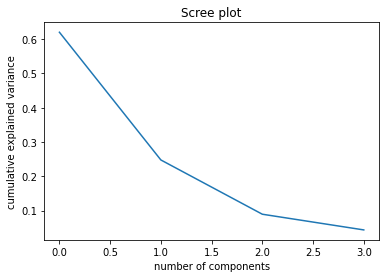

In [140]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

Above is a scree plot, which is a line lot of the eigenvalues of the principal components. This can help us determine the number of components to keep. Here it appears our first 3 components explain nearly all the variance. This means we can drop our 4th component and use the first 3 instead for our cluster analysis, meaning we've successfully reduced dimensionality.

In [142]:
#New df of our first three components
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
State,,,
Alabama,0.985566,1.133392,-0.444269
Alaska,1.950138,1.073213,2.040003
Arizona,1.763164,-0.745957,0.054781
Arkansas,-0.141420,1.119797,0.114574
California,2.523980,-1.542934,0.598557


## Clustering

### K-Means

For K-means clustering we need to specify k. To do this I am going to find the silhouette score for a few k values and choose whichever k has the highest silhouette score.

In [169]:
from sklearn.metrics import silhouette_score

def scatter_Kmeans(x, k, r=42):

    X = x.values.reshape(-1,2)
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(X)
    colours = 'rbgcmy'
    
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
    print(f'A k of {k} has a silhouette score of {score}')

for k in range(2,5):
  scatter_Kmeans(x_1, k, r=0)

A k of 2 has a silhouette score of 0.48
A k of 3 has a silhouette score of 0.4
A k of 4 has a silhouette score of 0.44


From the above we can see that the optimal amount of clusters k to choose is 2.

No handles with labels found to put in legend.


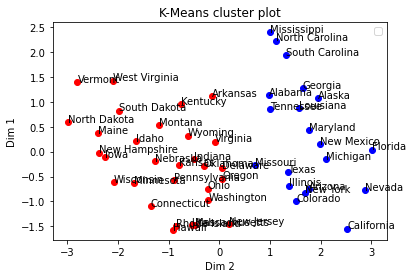

In [145]:
#From sample ipynb
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = pca_df.index[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

<AxesSubplot:xlabel='cluster labels', ylabel='Assault'>

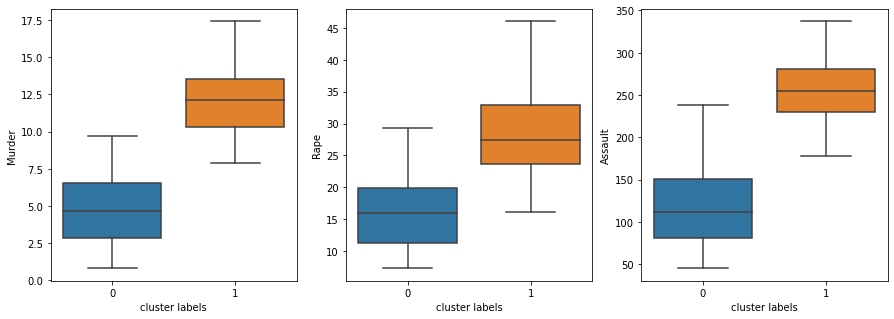

In [170]:
# Boxplots to display distribution of crime rates for the states in cluster 0 and cluster 1.
df['cluster labels']=cluster_labels
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
sns.boxplot(x='cluster labels', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='cluster labels', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='cluster labels', y='Assault', data=df, ax=ax[2])

From the above graphs we can see that there are two distinct groups of states. It appaears group 0 is much safer across the board, dsplaying lower levels of murder, rape, and assault arrests per 100,000 people than those states in group 1.

We can view the states in each group below:

In [185]:
#Loop through groups and print
for i in range(0,2):
    group_indices = np.argwhere(cluster_labels==i).transpose()[0]
    group = np.array(df.index)[group_indices]
    print(f'Group {i} States:', *group, sep=", ")
    print("\n")   

Group 0 States:, Arkansas, Connecticut, Delaware, Hawaii, Idaho, Indiana, Iowa, Kansas, Kentucky, Maine, Massachusetts, Minnesota, Montana, Nebraska, New Hampshire, New Jersey, North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, South Dakota, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming


Group 1 States:, Alabama, Alaska, Arizona, California, Colorado, Florida, Georgia, Illinois, Louisiana, Maryland, Michigan, Mississippi, Missouri, Nevada, New Mexico, New York, North Carolina, South Carolina, Tennessee, Texas




### Hierarchical Clustering

Below are dendrograms for ward, average, and complete linkage types:

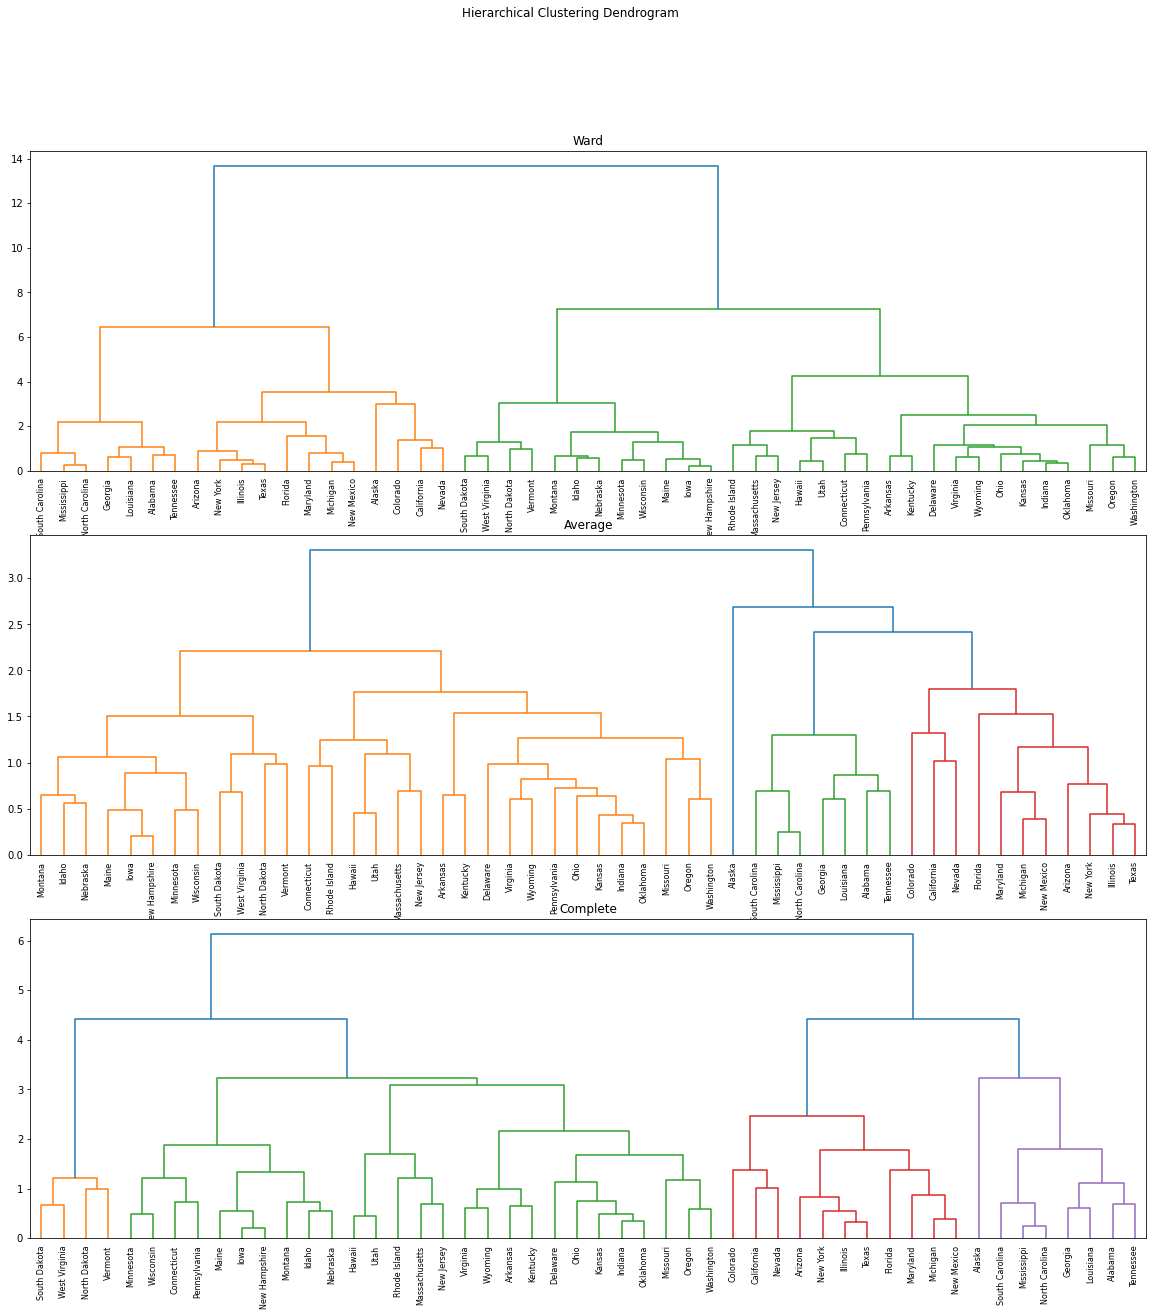

In [205]:
#Dendrogrms using the different linkages
#taken from ipynb notebook
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

plt.rcParams['figure.figsize'] = [20, 20]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Ward")
dendrogram(linkage(pca_df, method='ward'), labels=pca_df.index, ax=ax1) 

ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)

ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

The most spread out dendrogram above is the ward method, which has 2 clusters. We can now check the silhouette score using k=2 having determined this as an optimal clustering.

In [217]:
#Verify the clusters obtained by using the Silhouette score 
#Agglomerative hierarchical clustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
label = cluster.fit_predict(X)

#Silhouette Score
score = round(silhouette_score(X, label, metric='euclidean'),2)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.47


A silhouette score of 47, similar to before, was the highest of the clusters - confirming it as the best option. We can create the box plots and look at the relevant groups much like the before. I expect it will not be much different, if at all.

<AxesSubplot:xlabel='cluster labels', ylabel='Assault'>

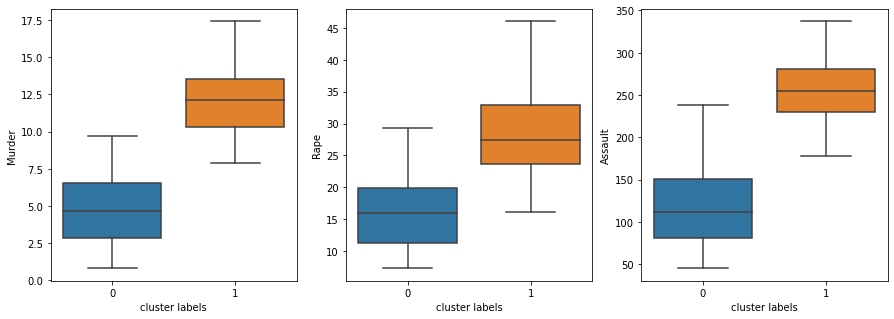

In [218]:
# Boxplots to display distribution of crime rates for the states in cluster 0 and cluster 1.
df['cluster labels']=cluster_labels
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
sns.boxplot(x='cluster labels', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='cluster labels', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='cluster labels', y='Assault', data=df, ax=ax[2])

In [219]:
#Loop through groups and print
for i in range(0,2):
    group_indices = np.argwhere(cluster_labels==i).transpose()[0]
    group = np.array(df.index)[group_indices]
    print(f'Group {i} States:', *group, sep=", ")
    print("\n") 

Group 0 States:, Arkansas, Connecticut, Delaware, Hawaii, Idaho, Indiana, Iowa, Kansas, Kentucky, Maine, Massachusetts, Minnesota, Montana, Nebraska, New Hampshire, New Jersey, North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, South Dakota, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming


Group 1 States:, Alabama, Alaska, Arizona, California, Colorado, Florida, Georgia, Illinois, Louisiana, Maryland, Michigan, Mississippi, Missouri, Nevada, New Mexico, New York, North Carolina, South Carolina, Tennessee, Texas




Our K-means clustering technique produced much the same results as our hierarchical clustering technique. We have used these models to distinguish between states that can be considered relatively high-crime vs low-crime based on their murder, rape, and assault rates.